<a href="https://colab.research.google.com/github/JSJeong-me/GPT-Graph/blob/main/20-multi-agent-collaboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Multi-agent Collaboration

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

![multi_agent diagram](https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/img/simple_multi_agent_diagram.png?raw=1)

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

In [ ]:
!pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib

In [ ]:
!pip install langgraph

In [1]:
!pip install python-dotenv

In [2]:
!echo "OPENAI_API_KEY=sk" >> .env
!echo "TAVILY_API_KEY=tvly-" >> .env
!echo "LANGCHAIN_API_KEY=ls_" >> .env
!source /content/.env

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
# Access the API key using the variable name defined in the .env file
api_key = os.getenv("OPENAI_API_KEY")
api_key = os.getenv("TAVILY_API_KEY")
api_key = os.getenv("LANGCHAIN_API_KEY")

In [3]:
# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [4]:
# import getpass
# import os


# def _set_if_undefined(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass(f"Please provide your {var}")


In [9]:
# _set_if_undefined("OPENAI_API_KEY")

In [ ]:
# _set_if_undefined("TAVILY_API_KEY")

In [ ]:
# _set_if_undefined("LANGCHAIN_API_KEY")


# Optional, add tracing in LangSmith
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

## Create Agents

The following helper functions will help create agents. These agents will then be nodes in the graph.

You can skip ahead if you just want to see what the graph looks like.

In [7]:
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)




## Define tools

We will also define some tools that our agents will use in the future

In [8]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"



## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [9]:
import operator
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union

from langchain.agents import create_openai_functions_agent
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

We now need to define the nodes. First, let's define the nodes for the agents.

In [10]:
import functools


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4-1106-preview")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Chart Generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.2.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


### Define Tool Node

We now define a node to run the tools

In [11]:
tools = [tavily_tool, python_repl]
tool_executor = ToolExecutor(tools)

def tool_node(state):
    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

### Define Edge Logic

We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [12]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        # The previus agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "end"
    return "continue"

### Define the Graph

We can now put it all together and define the graph!

In [13]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Chart Generator": "Chart Generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

{'Researcher': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"UK GDP past 5 years"}', 'name': 'tavily_search_results_json'}}, name='Researcher')], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [FunctionMessage(content='tavily_search_results_json response: [{\'url\': \'https://www.statista.com/topics/3795/gdp-of-the-uk/\', \'content\': \'Monthly GDP of the UK 2019-2023  Monthly GDP growth of the UK 2019-2023  Quarterly GDP growth of the UK 2019-2023  Quarterly GDP per capita in the UK 2019-2023Key Economic Indicators Monthly GDP of the UK 2019-2023 Key Economic Indicators Contribution to GDP growth in the UK 2023, by sector GDP GDP of the UK 1948-2022 GDP of the UK...\'}, {\'url\': \'https://www.statista.com/topics/6500/the-british-economy/\', \'content\': \'Quarterly GDP growth of the UK 2015-2023  Monthly GDP growth of the UK 2020-2023  Monthly GDP of the UK 1997-2023  Monthly growth of gross domestic product in the Unite

{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import requests\\nfrom bs4 import BeautifulSoup\\n\\n# Using requests to fetch the web page content\\nurl = \'https://www.statista.com/statistics/281744/gdp-of-the-united-kingdom/\'\\nresponse = requests.get(url)\\n\\n# Checking if the request was successful\\nif response.status_code == 200:\\n    # Using BeautifulSoup to parse the HTML content\\n    soup = BeautifulSoup(response.content, \'html.parser\')\\n    # Finding the script tag that contains the data for the GDP values\\n    script_tag = soup.find(\'script\', text=lambda t: \'Highcharts.chart(\' in t)\\n    if script_tag:\\n        print(\'Found the script containing the data.\')\\n    else:\\n        print(\'Script containing the data not found.\')\\nelse:\\n    print(f\'Failed to retrieve the web page, status code: {response.status_code}\')\\n"}', 'name': 'python_repl'}}, name='Chart Generator')], 'sender': '

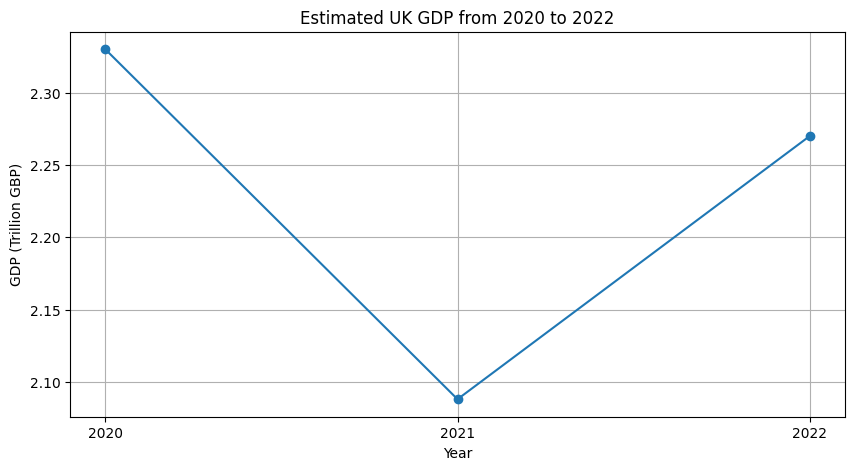

{'call_tool': {'messages': [FunctionMessage(content="python_repl response: Succesfully executed:\n```python\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Given GDP data and estimated values\nyears = np.array([2020, 2021, 2022])\ngdp_values = np.array([2.330, 2.088, 2.27])  # Trillion GBP\n\n# Plot the GDP data\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker='o')\n\n# Add titles and labels\nplt.title('Estimated UK GDP from 2020 to 2022')\nplt.xlabel('Year')\nplt.ylabel('GDP (Trillion GBP)')\nplt.xticks(years)\nplt.grid(True)\n\n# Show the graph\nplt.show()\n```\nStdout: ", name='python_repl')]}}
----
{'Chart Generator': {'messages': [HumanMessage(content='Here is the partial line graph for the estimated UK GDP from 2020 to 2022, based on the growth rates provided and the absolute value for 2022:\n\n![Estimated UK GDP from 2020 to 2022](sandbox:/code/execution/graphs/1b1c7e91-5b79-4f6f-81d6-034d1f9d7d02.png)\n\nThis graph only includes three years of data bec

In [14]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
):
    print(s)
    print("----")